# Practice with PySpark for Internship

The point of this notebook is to practice spark for the internship next week. I downloaded a .csv from kaggle and we will try to analyze it the same way we would if we were working with pandas.

In [146]:
from pyspark.sql import SparkSession
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# start a session
spark = SparkSession.builder.appName('Practice').getOrCreate()

In [147]:
# read the csv
data = spark.read.csv('Ecommerce Customers', header = True, inferSchema = True)
data.show(n = 3, vertical = True) # show the first 3

-RECORD 0------------------------------------
 Email                | mstephenson@ferna... 
 Address              | 835 Frank Tunnel     
 Avatar               | null                 
 Avg. Session Length  | null                 
 Time on App          | null                 
 Time on Website      | null                 
 Length of Membership | null                 
 Yearly Amount Spent  | null                 
-RECORD 1------------------------------------
 Email                | Wrightmouth          
 Address              |  MI 82180-9605"      
 Avatar               | Violet               
 Avg. Session Length  | 34.49726772511229    
 Time on App          | 12.655651149166752   
 Time on Website      | 39.57766801952616    
 Length of Membership | 4.082620632952961    
 Yearly Amount Spent  | 587.9510539684005    
-RECORD 2------------------------------------
 Email                | hduke@hotmail.com    
 Address              | 4547 Archer Common   
 Avatar               | null      

In [148]:
# what are the columns?
data.columns

['Email',
 'Address',
 'Avatar',
 'Avg. Session Length',
 'Time on App',
 'Time on Website',
 'Length of Membership',
 'Yearly Amount Spent']

In [150]:
# how many rows are there?
data.count()

1000

In [151]:
# some summary stats
### vertical = True will help with the formatting
data.summary().show(vertical = True)

-RECORD 0----------------------------------
 summary              | count              
 Email                | 1000               
 Address              | 1000               
 Avatar               | 500                
 Avg. Session Length  | 500                
 Time on App          | 500                
 Time on Website      | 500                
 Length of Membership | 500                
 Yearly Amount Spent  | 454                
-RECORD 1----------------------------------
 summary              | mean               
 Email                | null               
 Address              | null               
 Avatar               | 33.058900610740785 
 Avg. Session Length  | 31.130461514638228 
 Time on App          | 14.350284262734618 
 Time on Website      | 33.95692625943925  
 Length of Membership | 48.60730499130784  
 Yearly Amount Spent  | 499.91985771641924 
-RECORD 2----------------------------------
 summary              | stddev             
 Email                | null    

## EDA

In [152]:
# how many people gave a valid email address?
# we will say an email is valid if it has an "@" symbol
# I recognize this isn't exactly correct, but we're using it for pracice
valid_emails = data.filter(data['Email'].contains('@')) # the "contains" method is useful here
valid_emails.select('Email').show()

+--------------------+
|               Email|
+--------------------+
|mstephenson@ferna...|
|   hduke@hotmail.com|
|    pallen@yahoo.com|
|riverarebecca@gma...|
|mstephens@davidso...|
|alvareznancy@luca...|
|katherine20@yahoo...|
|  awatkins@yahoo.com|
|vchurch@walter-ma...|
|    bonnie69@lin.biz|
|andrew06@peterson...|
|ryanwerner@freema...|
|   knelson@gmail.com|
|wrightpeter@yahoo...|
|taylormason@gmail...|
| jstark@anderson.com|
| wjennings@gmail.com|
|rebecca45@hale-ba...|
|alejandro75@hotma...|
|samuel46@love-wes...|
+--------------------+
only showing top 20 rows



In [153]:
# so how many of them provided good emails?
valid_emails.count() # half of them

500

### Slicing the Data

In [154]:
# let's separate the data into those that used the website versus those that used the app most
website_df = data.filter(data['Time on Website'] > data['Time on App'])
app_df = data.filter(data['Time on Website'] < data['Time on App'])

In [155]:
print('Number of users that spent most time on the website: {}'.format(website_df.count()))
print('Number of users that spent most time on the app: {}'.format(app_df.count()))

Number of users that spent most time on the website: 454
Number of users that spent most time on the app: 46


As we can see from above, 454 users spent more time on the website while 46 spent more time on the app.

In [156]:
# do either of these df's contain nulls?
website_df.filter(website_df['Time on Website'].contains(None)).count()

0

In [157]:
# app_df contains nulls?
app_df.filter(app_df['Time on App'].contains(None)).count()

0

Which platform performs best? First let's take a look at how much time is spent on each respective platform.

In [158]:
website_df.describe('Time on Website').show()

+-------+------------------+
|summary|   Time on Website|
+-------+------------------+
|  count|               454|
|   mean| 37.05282185324883|
| stddev|0.9978633723120236|
|    min| 34.47687762925054|
|    max|40.005181638101895|
+-------+------------------+



I am going to assume that the units for this column are minutes. So on average, user's spend 37 minutes on the website.

In [159]:
# now app_df
app_df.describe('Time on App').show()

+-------+-----------------+
|summary|      Time on App|
+-------+-----------------+
|  count|               46|
|   mean|37.13568671955067|
| stddev|1.136952462614857|
|    min|33.91384724758464|
|    max|39.22071295098572|
+-------+-----------------+



It looks like both have similar averages. The users that use the app most spend an average of 37 minutes on the app.

Now let's find out which brings in the most money.

In [160]:
website_df.describe('Yearly Amount Spent').show()

+-------+-------------------+
|summary|Yearly Amount Spent|
+-------+-------------------+
|  count|                454|
|   mean| 499.91985771641924|
| stddev|   78.3257926883325|
|    min|   266.086340948469|
|    max|  765.5184619388372|
+-------+-------------------+



In [161]:
app_df.describe('Yearly Amount Spent').show()

+-------+-------------------+
|summary|Yearly Amount Spent|
+-------+-------------------+
|  count|                  0|
|   mean|               null|
| stddev|               null|
|    min|               null|
|    max|               null|
+-------+-------------------+



Well this was a little unexpected. For some reason, there is no data available for yearly amount spent for those that used the app most.

## Prepare Data for Analysis

We want to build a regression model using Spark. Before we do that, we will eliminate a few variables that will not be helpful, drop any missing values, and complete some visualizations.

In [162]:
# start by copying the data
df = data.alias('df')
df.show(n = 3, vertical = True)

-RECORD 0------------------------------------
 Email                | mstephenson@ferna... 
 Address              | 835 Frank Tunnel     
 Avatar               | null                 
 Avg. Session Length  | null                 
 Time on App          | null                 
 Time on Website      | null                 
 Length of Membership | null                 
 Yearly Amount Spent  | null                 
-RECORD 1------------------------------------
 Email                | Wrightmouth          
 Address              |  MI 82180-9605"      
 Avatar               | Violet               
 Avg. Session Length  | 34.49726772511229    
 Time on App          | 12.655651149166752   
 Time on Website      | 39.57766801952616    
 Length of Membership | 4.082620632952961    
 Yearly Amount Spent  | 587.9510539684005    
-RECORD 2------------------------------------
 Email                | hduke@hotmail.com    
 Address              | 4547 Archer Common   
 Avatar               | null      

In [163]:
# drop Email, address, and avatar.
# they don't hold any predictive power towards the yearly amount spent
df = df.drop('Email', 'Address', 'Avatar')
print(df.columns)
print(df.count())

['Avg. Session Length', 'Time on App', 'Time on Website', 'Length of Membership', 'Yearly Amount Spent']
1000


In [164]:
# yearly amount spent is our dependent variable, we will remove any rows that contains Null
df = df.na.drop(subset = 'Yearly Amount Spent')
df.count()

454

## Visualizations

Convert the df to pandas in order to use seaborn.

First we plot a pairplot to see any relationships.

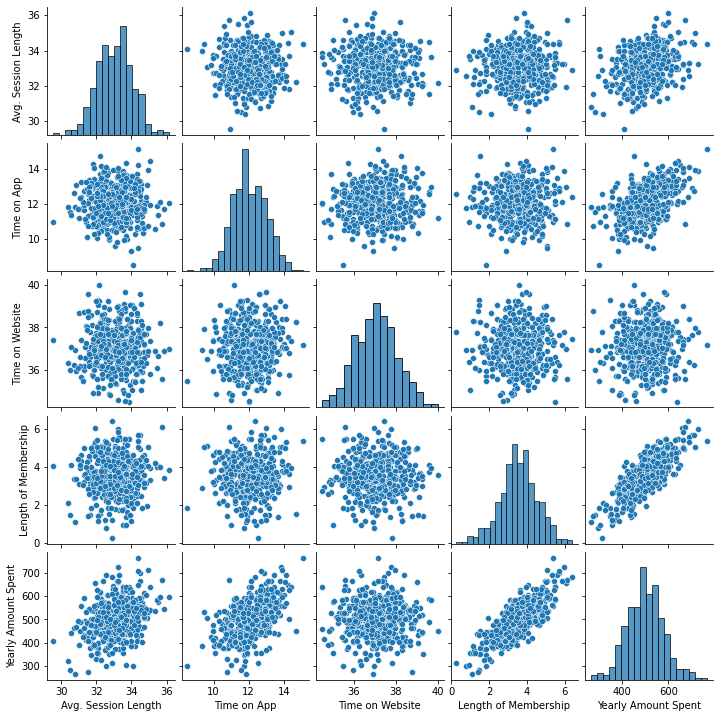

In [165]:
# convert to pandas so that seaborn can use it
df_pd = df.toPandas()

g = sns.pairplot(df_pd)
g.fig.set_size_inches(10,10) # change the figure size
plt.show()

We can see that Length of Membership and Time on App are positively correlated with Yearly Amount Spent. Avg Session Length is also slightly positively correlated with Yearly Amount Spent.

Let's visualize these correlations with a heatmap.

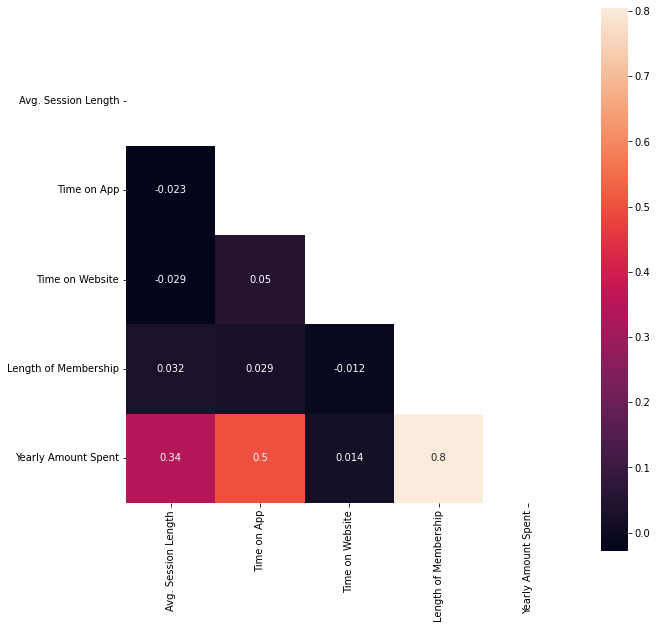

In [166]:
# get the correlations
corr = df_pd.corr()

# prepare mask for heatmap
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

# heatmap
fig, axs = plt.subplots(1,1, figsize = (10,10))
g = sns.heatmap(corr,
                annot = True,
                mask = mask,
                ax = axs,
                square = True)

plt.show()

The heatmap above confirms what we saw in the pairplot.

We will build two models. One will have all the independent features (Avg Session Length, Time on App, Time on Website, Length of Membership) as inputs and the second will have only the two most highly correlated with Yearly Amount Spent (Length of Membership and Time on App).

## Regression

We will build the first two models using Linear Regression. Then we will tune the best performing model and test to see if Lasso or Ridge would work better. 

If the model that uses the most features is best at first, then I think that Lasso would perform best when we try to optimize it.

In [167]:
# rename the columns so that they have no spaces
old_cols = ['Avg. Session Length', 'Time on App',
            'Time on Website', 'Length of Membership',
            'Yearly Amount Spent']

new_cols = ['Avg_Session_Length', 'Time_App',
            'Time_Website', 'Len_Of_Membership',
            'label']

for ind, col in enumerate(old_cols):
    df = df.withColumnRenamed(col, new_cols[ind])

df.show(n = 2)

+------------------+------------------+------------------+-----------------+-----------------+
|Avg_Session_Length|          Time_App|      Time_Website|Len_Of_Membership|            label|
+------------------+------------------+------------------+-----------------+-----------------+
| 34.49726772511229|12.655651149166752| 39.57766801952616|4.082620632952961|587.9510539684005|
|31.926272026360156|11.109460728682564|37.268958868297744| 2.66403418213262|392.2049334443264|
+------------------+------------------+------------------+-----------------+-----------------+
only showing top 2 rows



In [169]:
# first we use the vector assembler to combine the independent features together
from pyspark.ml.feature import VectorAssembler

# the first is the model with all features
vectAssembler1 = VectorAssembler(inputCols = ['Avg_Session_Length', 'Time_App',
                                              'Time_Website', 'Len_Of_Membership'],
                                 outputCol = 'features')

# the second is the model with the two features most correlated with the target
vectAssembler2 = VectorAssembler(inputCols = ['Time_App', 'Len_Of_Membership'],
                                 outputCol = 'features')

# transform
df1 = vectAssembler1.transform(df).select(['features', 'label'])
df2 = vectAssembler2.transform(df).select(['features', 'label'])

In [170]:
# check that is worked
df1.show(n = 2, vertical = True)

-RECORD 0------------------------
 features | [34.4972677251122... 
 label    | 587.9510539684005    
-RECORD 1------------------------
 features | [31.9262720263601... 
 label    | 392.2049334443264    
only showing top 2 rows



In [171]:
# check that it worked
df2.show(n = 2, vertical = True)

-RECORD 0------------------------
 features | [12.6556511491667... 
 label    | 587.9510539684005    
-RECORD 1------------------------
 features | [11.1094607286825... 
 label    | 392.2049334443264    
only showing top 2 rows



Now we split the data.

In [172]:
train1, test1 = df1.randomSplit([0.8, 0.2])
train2, test2 = df2.randomSplit([0.8, 0.2])

In [205]:
# start the regression
from pyspark.ml.regression import LinearRegression

LR1 = LinearRegression()

LR2 = LinearRegression()

# now we fit it to the training set
LR1_fitted = LR1.fit(train1)
LR2_fitted = LR2.fit(train2)

In [203]:
# evaluate how well the models performed with default params

def evaluate_models(model_dict):
    for model in model_dict:
        print('====================================================')
        print('Summary of Performance for ' + model)
        print('R2 score: {}'.format(model_dict[model].summary.r2))
        print('RMSE score: {}'.format(model_dict[model].summary.rootMeanSquaredError))
        print('====================================================\n\n')

        
model_dict = {'All Features' : LR1_fitted,
              '2 Features' : LR2_fitted}

evaluate_models(model_dict)

Summary of Performance for All Features
R2 score: 0.9841266697976236
RMSE score: 9.850093814883206


Summary of Performance for 2 Features
R2 score: 0.8806909118967033
RMSE score: 26.91243323283319




As we can see from above, the model with all the features inputted performed better than the one with only two features.

We have an R-Squared score of ~98%, which means most 98% of the data can be explained pretty well by our regression line. The RMSE score of 9.85 means that the model is on average wrong by about $9.85.

### Parameter Tuning using PySpark

I have never seen parameter tuning in any other library other than Sklearn so this will be interesting to see.

In [206]:
# import relevant packages

# cross validator
from pyspark.ml.tuning import CrossValidator
# param grid builder
from pyspark.ml.tuning import ParamGridBuilder
# evaluator for regression
from pyspark.ml.evaluation import RegressionEvaluator

In [207]:
# using the \ {new line} notation for the first time
LR = LinearRegression()

evaluator = RegressionEvaluator()
grid = ParamGridBuilder()\
    .addGrid(LR.maxIter, [50, 100, 200])\
    .addGrid(LR.elasticNetParam, [0, 0.5, 1])\
    .addGrid(LR.regParam, [0.0, 0.1, 0.5])\
    .build()

# this gives us 27 different regressions to test

In [208]:
cv = CrossValidator(estimator = LR,
                    estimatorParamMaps = grid,
                    evaluator = evaluator,
                    numFolds = 5,
                    seed = 42)

cv_model = cv.fit(train1)

In [223]:
best_model = cv_model.bestModel
max_iter = best_model._java_obj.getMaxIter()
elasticNet = best_model._java_obj.getElasticNetParam()
regParam = best_model._java_obj.getRegParam()

print('Max Iter Param: {}'.format(max_iter))
print('Elastic Net Param: {}'.format(elasticNet))
print('Regularization Param : {}'.format(regParam))
# elastic net == 0 means it is Ridge regression

Max Iter Param: 50
Elastic Net Param: 0.0
Regularization Param : 0.0


In [218]:
best_model_dict = {'Best Model' : best_model}
evaluate_models(best_model_dict)

Summary of Performance for Best Model
R2 score: 0.9841266697976236
RMSE score: 9.850093814883206




What we can see from above is that the best model found from using Grid Search and Cross Validation is the same as the initial model that we trained without Grid Search.

We will see how this model performs with the test set.

In [232]:
preds = best_model.transform(test1)

# by default it will return the rmse
rmse_evaluator = RegressionEvaluator(predictionCol = 'prediction',
                                     labelCol = 'label')
rmse = rmse_evaluator.evaluate(preds)

# now we do r-squared
r2_evaluator = RegressionEvaluator(predictionCol = 'prediction',
                                     labelCol = 'label',
                                     metricName = 'r2')
r2 = r2_evaluator.evaluate(preds)

print('RMSE of Test Set: {}'.format(rmse))
print('R-Squared of Test Set: {}'.format(r2))

RMSE of Test Set: 10.337698844675911
R-Squared of Test Set: 0.9823549167374169


We can see that the final model performs slightly worse on the test set than the training set. That is expected but the difference in errors is small (the error between the test and train RMSE scores is off by 50 cents). 

The R-Squared score for the test set is ~98%, almost exactly the same as the training set.

## Gradient Boosted Trees Regression

Let's see if we can beeat the previous Linear Regression model with the GBTRegression model.

In [233]:
from pyspark.ml.regression import GBTRegressor

In [228]:
# first we train without changing the hyperparams
GBTReg = GBTRegressor(seed = 42)

GBT_trained = GBTReg.fit(train1)

In [234]:
# get predictions for training set and check rmse and r2 scores
train_preds = GBT_trained.transform(train1)
rmse = rmse_evaluator.evaluate(train_preds)
r2 = r2_evaluator.evaluate(train_preds)

print('RMSE of Train Set: {}'.format(rmse))
print('R-Squared of Train Set: {}'.format(r2))

RMSE of Train Set: 10.039664805626469
R-Squared of Train Set: 0.9835098068150031


Now let's try to tune the hyperparameters for this regression model.

In [235]:
GBT = GBTRegressor(seed = 42)
grid = ParamGridBuilder()\
    .addGrid(GBT.lossType, ['squared', 'absolute'])\
    .addGrid(GBT.maxBins, [4,16,32,64])\
    .addGrid(GBT.maxIter, [20, 50, 100])\
    .addGrid(GBT.stepSize, [0.01, 0.2, 0.5])\
    .build()

evaluator = RegressionEvaluator()

cv = CrossValidator(estimator = GBT,
                    estimatorParamMaps = grid,
                    evaluator = evaluator,
                    numFolds = 5,
                    seed = 42)

cv_gbt_fitted = cv.fit(train1)

In [236]:
best_model_gbt = cv_gbt_fitted.bestModel
lossType = best_model_gbt._java_obj.getLossType()
maxBins = best_model_gbt._java_obj.getMaxBins()
maxIter = best_model_gbt._java_obj.getMaxIter()
stepSize = best_model_gbt._java_obj.getStepSize()

In [237]:
print('Loss Type: {}'.format(lossType))
print('maxBins: {}'.format(maxBins))
print('maxIter: {}'.format(maxIter))
print('stepSize: {}'.format(stepSize))

Loss Type: squared
maxBins: 16
maxIter: 100
stepSize: 0.2


In [254]:
import os
import pickle
CWD = os.getcwd()

In [255]:
# save the model so that we can use it later
model_path = os.path.join(CWD, 'GBT_Regressor_pickle')
with open(model_path, 'wb') as f:
    pickle.dump(best_model_gbt, f)

TypeError: cannot pickle '_thread.RLock' object